## Import package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation, BatchNormalization, Conv1D, CuDNNGRU, CuDNNLSTM, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
import time

%matplotlib inline

C:\Users\f2002\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\f2002\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
C:\Users\f2002\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _registe

## Get the data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat((train_text, test_text))
print('The train\'s shape is {}'.format(train.shape))
print('The test\'s shape is {}'.format(test.shape))

The train's shape is (159571, 8)
The test's shape is (153164, 2)


In [3]:
train_target = train.drop(['id', 'comment_text'], axis = 1)
print('The target\'s shape is {}'.format(train_target.shape))

The target's shape is (159571, 6)


## Display the target structure

In [4]:
train_target.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5,0,'num of labels')

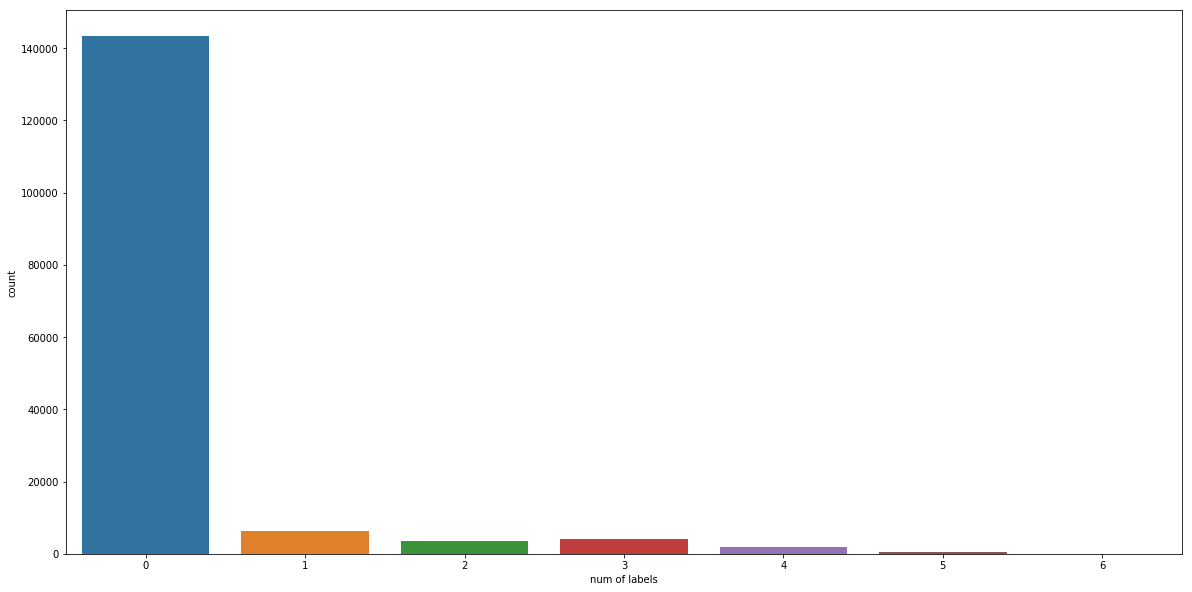

In [8]:
plt.subplots(figsize=(20, 10))
sb.countplot(data = train_target.sum(axis = 1), x = train_target.sum(axis = 1).index)
plt.xlabel('num of labels')

Text(0,0.5,'percentage of total labels')

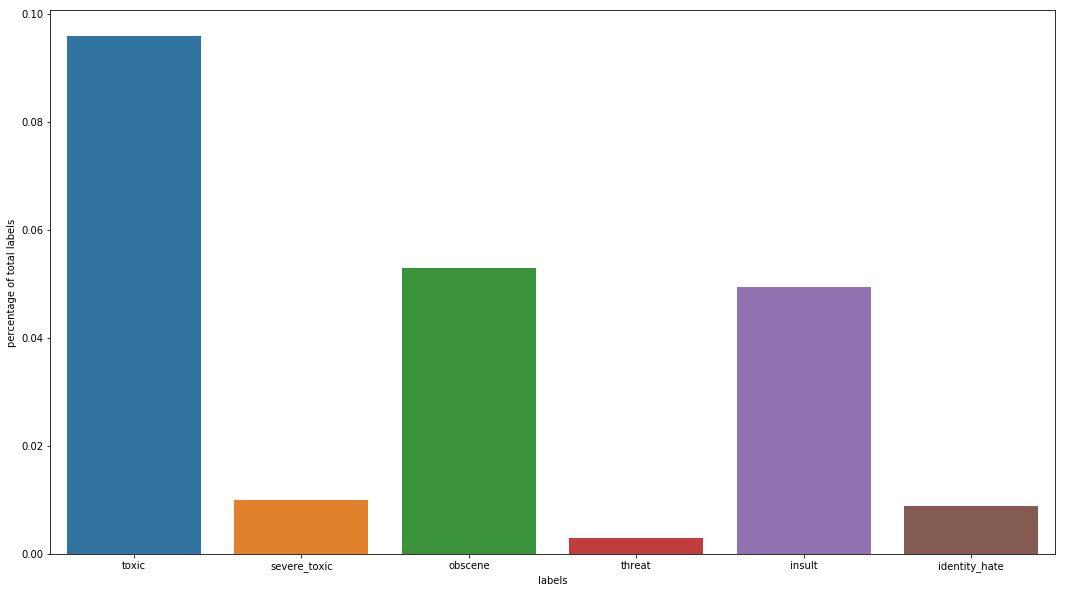

In [47]:
plt.subplots(figsize = (18, 10))
sb.barplot(x = train_target.sum().index, y = train_target.sum()/train_target.shape[0])
plt.xlabel('labels')
plt.ylabel('percentage of total labels')

As we seen above, this project is unbalance, and have multiple lables. 

In [5]:
lens = all_text.str.len()
print('The mean of total length is {}'.format(lens.mean()))
print('The std of total length is {}'.format(lens.std()))
print('The min of total length is {}'.format(lens.min()))
print('The max of total length is {}'.format(lens.max()))

The mean of total length is 379.7732617071962
The std of total length is 591.7677911923058
The min of total length is 1
The max of total length is 5000


Text(0,0.5,'counts')

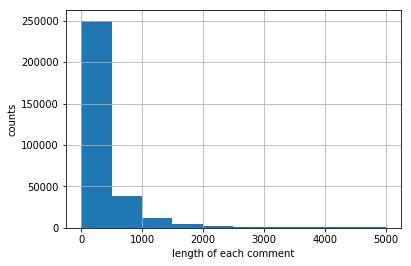

In [6]:
lens.hist()
plt.xlabel('length of each comment')
plt.ylabel('counts')

## Process the text data

#### tf-idf method

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_union
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    max_features=30000)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=30000)

vectorizer = make_union(word_vectorizer, char_vectorizer)

In [84]:
tf_start = time.time()
vectorizer.fit(all_text)
train_feature = vectorizer.transform(train_text)
test_feature = vectorizer.transform(test_text)
tf_end = time.time()
tf_time = tf_end - tf_start
print("tf-idf method used {} seconds".format(tf_time))

tf-idf method used 485.7565772533417 seconds


In [21]:
sample = train_text[0:1]
print(train_text[0])
print(train_feature.shape)
print(test_feature.shape)

explanation why the edits made under my username hardcore metallica fan were reverted? they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 
(159571, 60000)
(153164, 60000)


In [22]:
sample_feature = word_vectorizer.transform(sample)
word_array = sample_feature.toarray()
word_array.shape

(1, 30000)

#### Fasttext method

In [56]:
embed_size = 300 # how big is each word vector
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [57]:
#glove_path_200d = open("F:\word2vec\glove\glove.twitter.27B.200d.txt", encoding = 'UTF-8')
#glove_path_25d = open("F:\word2vec\glove\glove.twitter.27B.25d.txt", encoding = 'UTF-8')
#glove_lines_200d = [line for line in glove_path_200d]
#glove_lines_25d = [line for line in glove_path_25d]
fasttext = open('F:/fasttext/crawl-300d-2M.vec', encoding = 'UTF-8')
fasttext_lines = [line for line in fasttext]

In [9]:
def special_char(df, column, df_p):
    df_p[column] = df[column].str.replace(r"http\S+", "")
    df_p[column] = df[column].str.replace(r"http", "")
    df_p[column] = df[column].str.replace(r"@\S+", "")
    df_p[column] = df[column].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df_p[column] = df[column].str.replace(r"@", "at")
    df_p[column] = df[column].str.lower()
    return df_p

tokenizer = nltk.RegexpTokenizer(r'\w+')
stopwords = set(nltk.corpus.stopwords.words('english'))

In [58]:
gl_start = time.time()

'''
st = nltk.stem.SnowballStemmer('english')
train_clearn = pd.DataFrame()
train_clearn = special_char(train, 'comment_text', train_clearn)
train_clearn['comment_text'] = train_clearn['comment_text'].astype('str')
train_clearn['comment_text'] = train_clearn['comment_text'].apply(tokenizer.tokenize)
train_clearn['comment_text'] = train_clearn['comment_text'].apply(lambda vec: [word for word in vec if word not in stopwords]) 
train_clearn['comment_text'] = train_clearn['comment_text'].apply(lambda vec: [st.stem(word) for word in vec])
test_clearn = pd.DataFrame()
test_clearn = special_char(test, 'comment_text', test_clearn)
test_clearn['comment_text'] = test_clearn['comment_text'].astype('str')
test_clearn['comment_text'] = test_clearn['comment_text'].apply(tokenizer.tokenize)
test_clearn['comment_text'] = test_clearn['comment_text'].apply(lambda vec: [word for word in vec if word not in stopwords])
test_clearn['comment_test'] = test_clearn['comment_text'].apply(lambda vec: [st.stem(word) for word in vec])

train_words = [word for tokens in train_clearn['comment_text'] for word in tokens]
train_sequence_length = [len(sequence) for sequence in train_clearn['comment_text']]
num_train_words = len(set(train_words))

test_words = [word for tokens in test_clearn['comment_text'] for word in tokens]
test_sequence_length = [len(sequence) for sequence in test_clearn['comment_text']]
num_test_words = len(set(test_words))
'''

list_sentences_train = train['comment_text'].fillna('NA').values
list_sentences_test = test['comment_text'].fillna('NA').values

#all_words = [list(list_sentences_train) + list(list_sentences_test)]

tokenizer_kp = Tokenizer(num_words=max_features)
tokenizer_kp.fit_on_texts(list(list_sentences_train) + list(list_sentences_test))
list_tokenized_train = tokenizer_kp.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer_kp.texts_to_sequences(list_sentences_test)
X_train = pad_sequences(list_tokenized_train, maxlen = maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen = maxlen)

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
word_dict = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in fasttext_lines)


#all_emd = np.stack(word_dict.values())
#mean_emd, std_emd = all_emd.mean(), all_emd.std()


word_index = tokenizer_kp.word_index
nb_words = min(max_features, len(word_index))
#embedding_matrix = np.random.normal(mean_emd, std_emd, (nb_words, embed_size))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = word_dict.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
gl_end = time.time()
gl_time = gl_end - gl_start
print('The shape of train features is {}'.format(X_train.shape))
print('The shape of test features is {}'.format(X_test.shape))
print("Fasttext method used {} sceconds".format(gl_time))

The shape of train features is (159571, 100)
The shape of test features is (153164, 100)
Fasttext method used 194.303395986557 sceconds


In [9]:
X_train.shape

(159571, 300)

### Implementation

#### RL

In [9]:
classes = []
scores = []
for col in train_target:
    classes.append(col)
result = np.zeros((len(test), len(classes)))
sub_id = pd.DataFrame({'id': test['id']})

In [75]:
for col in classes:
    print(classes.index(col))

0
1
2
3
4
5


In [85]:
lr_start = time.time()
for class_name in classes:
    target = train_target[class_name]
    classifier = LogisticRegression()
    #x_nv = get_nv(train_feature, target)
    cv_score = np.mean(cross_val_score(classifier, train_feature, target, cv=5, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
   
    classifier.fit(train_feature, target)
    #predictions = classifier.predict(X_val)
    #score = roc_auc_score(predictions, y_val[class_name])
    #scores.append(score)
    #print('The auc score for class {} is {}'.format(class_name, score))    
    result[:, classes.index(class_name)] = classifier.predict_proba(test_feature)[:, 1]
lr_end = time.time()
lr_time = lr_end - lr_start
print('Total CV score is {}'.format(np.mean(scores)))
print('logisticregression method used {} seconds'.format(lr_time))


CV score for class toxic is 0.978562240655755
CV score for class severe_toxic is 0.9883988211915747
CV score for class obscene is 0.9901930051444021
CV score for class threat is 0.9896602608127049
CV score for class insult is 0.982993101524724
CV score for class identity_hate is 0.9830561669074912
Total CV score is 0.985477266039442
logisticregression method used 647.3229742050171 seconds


In [61]:
result[:1]

,id
0,00001cee341fdb12


In [86]:
submission_lr = pd.concat([sub_id, pd.DataFrame(result, columns = classes)], axis=1)
submission_lr.to_csv('submission_lr.csv', index=False)

In [ ]:
plt.bar(classes, result.loc[0].drop('id'))
plt.xlabel('classes')
plt.ylabel('probability')

#### LSTM

In [59]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch + 1, score))

np.random.seed = 42
[X_tr, X_val, y_tr, y_val] = train_test_split(X_train, train_target, train_size=0.95, random_state = 233)

ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

C:\Users\f2002\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [72]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
#x = BatchNormalization()(x)
x = Bidirectional(CuDNNLSTM(80, return_sequences=True))(x)
#x = SpatialDropout1D(0.2)(x)
#x = Dropout(0.2)(x)
#x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
#x = SpatialDropout1D(0.2)(x)
#x = Conv1D(60, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)
gm = GlobalMaxPooling1D()(x)
ga = GlobalAveragePooling1D()(x)
co = concatenate([gm, ga])

#x = Dense(100, activation='relu')(gm)
#x = Dropout(0.6)(x)
x = Dense(6, activation="sigmoid")(co)
model_l = Model(inputs=inp, outputs=x)
  
model_l.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
ls_start = time.time()
history_l = model_l.fit(X_tr, y_tr, validation_data=(X_val, y_val), 
                        batch_size=32, epochs = 20, 
                        callbacks=[ra_val, EarlyStopping(monitor='val_loss', mode='auto', patience=0)])
ls_end = time.time()
ls_time = ls_end - ls_start
print('LSTM method used {} seconds'.format(ls_time))


Train on 151592 samples, validate on 7979 samples
Epoch 1/20
151592/151592 [==============================] - 58s 385us/step - loss: 0.0545 - acc: 0.9808 - val_loss: 0.0482 - val_acc: 0.9821

 ROC-AUC - epoch: 1 - score: 0.983402
Epoch 2/20
151592/151592 [==============================] - 55s 363us/step - loss: 0.0433 - acc: 0.9836 - val_loss: 0.0452 - val_acc: 0.9828

 ROC-AUC - epoch: 2 - score: 0.985927
Epoch 3/20
151592/151592 [==============================] - 55s 361us/step - loss: 0.0408 - acc: 0.9843 - val_loss: 0.0447 - val_acc: 0.9828

 ROC-AUC - epoch: 3 - score: 0.986337
Epoch 4/20
151592/151592 [==============================] - 56s 371us/step - loss: 0.0390 - acc: 0.9850 - val_loss: 0.0443 - val_acc: 0.9830

 ROC-AUC - epoch: 4 - score: 0.986663
Epoch 5/20
151592/151592 [==============================] - 56s 367us/step - loss: 0.0371 - acc: 0.9857 - val_loss: 0.0443 - val_acc: 0.9832

 ROC-AUC - epoch: 5 - score: 0.986722
LSTM method used 286.62156200408936 seconds


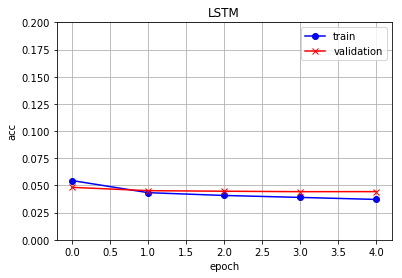

In [77]:
plt.plot(history_l.history['loss'], color = 'blue', marker = 'o', label = 'train')
plt.plot(history_l.history['val_loss'], color = 'red', marker = 'x', label = 'validation')
plt.title('LSTM')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(loc = 'upper right')
plt.ylim([0, 0.2])
plt.show()


In [78]:
prediction_lstm = model_l.predict(X_test, batch_size = 1024, verbose = 1)

153164/153164 [==============================] - 6s 42us/step


In [79]:
submission_lstm = pd.concat([sub_id, pd.DataFrame(prediction_lstm, columns = classes)], axis = 1)
submission_lstm.to_csv('submission_lstm.csv', index = False)

#### GRU

In [74]:
inp = Input(shape=(maxlen, ))
g = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
g = SpatialDropout1D(0.2)(g)
#g = BatchNormalization()(g)
g = Bidirectional(CuDNNGRU(80, return_sequences=True))(g)
#g = MaxPooling1D()(g)
#g = SpatialDropout1D(0.4)(g)
#g = Bidirectional(CuDNNGRU(128, return_sequences=True))(g)
#g = SpatialDropout1D(0.2)(g)
#x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(g)
avg_pool = GlobalAveragePooling1D()(g)
max_pool = GlobalMaxPooling1D()(g)
#at = Attention(maxlen)(g)
conc = concatenate([avg_pool, max_pool])

#g = Dense(80, activation = 'relu')(max_pool)
#g = Dropout(0.1)(g)
#g = Dense(512, activation = 'relu')(g)
#g = Dropout(0.2)(g)
g = Dense(6, activation="sigmoid")(conc)
    
model_g = Model(inputs=inp, outputs=g)
model_g.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [75]:
g_start = time.time()
history_g = model_g.fit(X_tr, y_tr, validation_data = (X_val, y_val), 
                        batch_size=32, epochs=20, 
                        callbacks=[ra_val, EarlyStopping(monitor='val_loss', mode='auto', patience=0)])
g_end = time.time()
g_time = g_end - g_start
print('GRU method used {} seconds'.format(g_time))


Train on 151592 samples, validate on 7979 samples
Epoch 1/20
151592/151592 [==============================] - 57s 373us/step - loss: 0.0519 - acc: 0.9814 - val_loss: 0.0473 - val_acc: 0.9827

 ROC-AUC - epoch: 1 - score: 0.985610
Epoch 2/20
151592/151592 [==============================] - 53s 351us/step - loss: 0.0428 - acc: 0.9837 - val_loss: 0.0455 - val_acc: 0.9827

 ROC-AUC - epoch: 2 - score: 0.985975
Epoch 3/20
151592/151592 [==============================] - 53s 348us/step - loss: 0.0405 - acc: 0.9845 - val_loss: 0.0458 - val_acc: 0.9821

 ROC-AUC - epoch: 3 - score: 0.986783
GRU method used 167.11472511291504 seconds


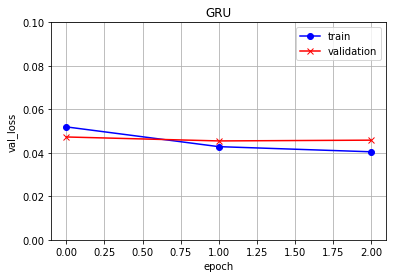

In [76]:
plt.plot(history_g.history['loss'], color = 'blue', marker = 'o', label = 'train')
plt.plot(history_g.history['val_loss'], color = 'red', marker = 'x', label = 'validation')
plt.grid()
plt.title('GRU')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend(loc = 'upper right')
plt.ylim([0, 0.1])
plt.show()

In [80]:
prediction_gru = model_g.predict(X_test, batch_size=1024, verbose=1)

153164/153164 [==============================] - 5s 35us/step


In [81]:
submission_gru = pd.concat([sub_id, pd.DataFrame(prediction_gru, columns = classes)], axis = 1)
submission_gru.to_csv('submission_gru.csv', index=False)

In [29]:
submission_gru.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999147,3.087803e-01,0.962581,1.754768e-02,9.743233e-01,3.103907e-01
1,0000247867823ef7,0.000006,3.986464e-10,0.000002,1.176802e-09,1.539694e-07,1.331353e-07
2,00013b17ad220c46,0.003075,1.279916e-05,0.001629,1.864584e-05,3.729791e-04,1.801671e-04
3,00017563c3f7919a,0.000074,5.830867e-09,0.000006,4.505953e-08,2.272762e-06,9.919169e-07
4,00017695ad8997eb,0.000805,3.194636e-07,0.000170,1.039108e-06,4.869772e-05,1.939688e-05


### Try model blend

In [89]:
for col in classes:
    print(col)
    print(np.corrcoef([submission_lr[col].rank(pct=True), submission_gru[col].rank(pct=True), submission_lstm[col].rank(pct=True)]))

submission_bl = pd.DataFrame()
submission_bl['id'] = sub_id
for col in classes:
    submission_bl[col] = submission_lr[col].rank(pct=True) * 0.35 + submission_gru[col].rank(pct=True) * 0.35 + submission_lstm[col].rank(pct=True) * 0.3

submission_bl.to_csv('submission_bl.csv', index=False)

toxic
[[1.         0.88083    0.88248772]
 [0.88083    1.         0.9665347 ]
 [0.88248772 0.9665347  1.        ]]
severe_toxic
[[1.         0.82468377 0.82733741]
 [0.82468377 1.         0.96053309]
 [0.82733741 0.96053309 1.        ]]
obscene
[[1.         0.82654482 0.82494234]
 [0.82654482 1.         0.95443882]
 [0.82494234 0.95443882 1.        ]]
threat
[[1.         0.77293302 0.79330982]
 [0.77293302 1.         0.92561526]
 [0.79330982 0.92561526 1.        ]]
insult
[[1.         0.83991293 0.8439047 ]
 [0.83991293 1.         0.96224096]
 [0.8439047  0.96224096 1.        ]]
identity_hate
[[1.         0.81575979 0.81611268]
 [0.81575979 1.         0.95202863]
 [0.81611268 0.95202863 1.        ]]
